In [8]:
_author_ = "Rahul_Chowdhury"
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as mp
from collections import defaultdict
print(sys.version)

3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


In [10]:
Data = pd.read_csv("data-folder/AMLInventorySites2017_01_Changed.csv", header=None)
#k = len(list(Data['V5'].unique())) #counting the number of classes in the last column
new_header = Data.iloc[0] #grab the first row for the header
Data = Data[2:] #take the data less the header row
Data = Data.rename(columns = new_header) #set the header row as the df header
Data['total_feat'] = Data['total_feat'].astype('int64')
Data['features_r'] = Data['features_r'].astype('int64')
Data['Shape_Length'] = Data['Shape_Length'].astype('float64')
Data['Shape_Area'] = Data['Shape_Area'].astype('float64')


Data.head(10)

,total_feat,features_r,pf_status,Shape_Length,Shape_Area
2,3,3,Reclamation Complete,1788.797154,2.400819e+05
3,2,2,Reclamation Complete,2716.873354,4.948574e+05
4,4,4,Reclamation Complete,2080.211772,3.072929e+05
5,1,1,Reclamation Complete,1645.146630,2.103056e+05
6,1,1,Reclamation Complete,3450.931356,8.017419e+05
7,11,11,Reclamation Complete,2730.163563,5.707787e+05
8,7,7,Reclamation Complete,4846.888662,1.025933e+06
9,5,5,Reclamation Complete,4508.355956,5.894399e+05
10,3,3,Reclamation Complete,2505.891189,3.412919e+05
11,2,2,Reclamation Complete,5382.085666,1.170818e+06


In [11]:
pf_status_list = Data['pf_status'].unique()
print(pf_status_list)
values_in_col_name1 =  list(Data['features_r'].unique()) #extracting each unique value in column1
print(values_in_col_name1)

['Reclamation Complete' 'Inactive' 'Abandoned' 'Active'
 'AML Inventory List']
[3, 2, 4, 1, 11, 7, 5, 6, 8, 12, 0, 9, 36, 10, 16, 21, 18, 13, 25, 19]


In [12]:
pf_status_dict = {'Reclamation Complete' :1, 'Inactive':2, 'Abandoned' :3, 'Active':4, 'AML Inventory List':5}
Data['pf_status'] = Data['pf_status'].map(pf_status_dict)

Data.head(10)

,total_feat,features_r,pf_status,Shape_Length,Shape_Area
2,3,3,1,1788.797154,2.400819e+05
3,2,2,1,2716.873354,4.948574e+05
4,4,4,1,2080.211772,3.072929e+05
5,1,1,1,1645.146630,2.103056e+05
6,1,1,1,3450.931356,8.017419e+05
7,11,11,1,2730.163563,5.707787e+05
8,7,7,1,4846.888662,1.025933e+06
9,5,5,1,4508.355956,5.894399e+05
10,3,3,1,2505.891189,3.412919e+05
11,2,2,1,5382.085666,1.170818e+06


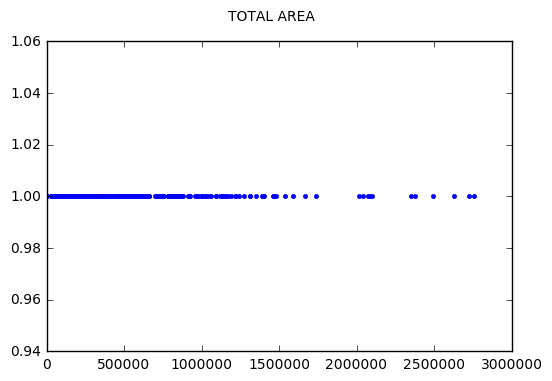

In [13]:
mp.plot(Data['Shape_Area'],len(Data['Shape_Area']) * [1], ".")
mp.suptitle("TOTAL AREA")
mp.show()



In [14]:
#Data = Data.drop('Shape_Area', axis=1)
#binning of decision attribute
classes = [1,2,3]
bins = [-1,1000000,2000000,3000000]
Data['class'] = pd.cut(Data['Shape_Area'], bins, labels = classes)
Data.head(10)
Data.to_csv("binning_data.csv")

In [7]:
cluster2_numerical_global = [] #global variable

def MMeR(U,k):
    C =  {}#the clusters made through MMeR alogrithm
    C_distance = {}
    Rough_Data = U.copy()
    index = 0
   
    while(7>len(C.keys())):
         
        split_attr,min_roughness_attr_value = mmer_roughness(Rough_Data)
        print(split_attr)
        #min_roughness_attr_value = min(roughness_list_dict[split_attr]) #find the min. value of min_roughness_attr for which alpha is minimum
        #print(min_roughness_attr_value)
        if(split_attr == 'Shape_Length'):
            cluster1 = cluster1_numerical_global
            #print("split-cluster1",cluster1 )
            cluster2 = cluster2_numerical_global
            #print("split-cluster2",cluster2 )
        else:    
            cluster1 = Rough_Data[Rough_Data[split_attr] == min_roughness_attr_value].index.tolist()
            cluster2 = Rough_Data.loc[Rough_Data[split_attr] != min_roughness_attr_value].index.tolist()
        cluster1_distance = 0
        cluster2_distance = 0
        if(len(cluster1) == 1):
           cluster1_distance = 0
        else:
            cluster1_distance = cluster_distance(cluster1, Data) #calculating the cluster distance of cluster1
        if(len(cluster2) == 1):
           cluster2_distance = 0
        else:
            cluster2_distance = cluster_distance(cluster2, Data) #calculating the cluster distance of cluster2
            
        C[index] = cluster1
        C_distance[index] = cluster1_distance
        index += 1
        C[index] = cluster2
        C_distance[index] = cluster2_distance
        index += 1
        max_index = max(C_distance, key= C_distance.get) #find the index with the max cluster distance
        
              
        Rough_Data = U.ix[C[max_index]]  #send data of cluster with max distance
        for key in C:
            print("Cluster",key, C[key])
            print("Cluster distance", C_distance[key])
      
        
        if(len(C.keys())!= (k-1)):
               
            del C[max_index]
            del C_distance[max_index]
        
        print("C length:",len(C.keys()))
       
        
        
    


    
    
def roughness(col_name1, col_name2, val, Data):
     
     equiv_class_dict = {} #dictionary storing equiv classes for all attribute
     for col in Data:
        equiv_class_dict[col] =list(Data.groupby([col]))
        
     arr = equiv_class_dict[col_name2] #group equiv classes according to column2
     target_set = Data[Data[col_name1] == val].index.tolist() #calculating target set for each unique value in column1
     lower_approx = []
     upper_approx = []
     for name,group in arr:
       selected_list = list(group.index)
       if(set(selected_list).issubset(target_set)): #if a subset, then append to lower_approx
            lower_approx.append(selected_list)
       if(set(selected_list) & set(target_set)): #if intersection is not null, then append to upper_approx
            upper_approx.append(selected_list)
     lower_approx_count = sum(map(len, lower_approx)) #count the no. of elements in lower_approx
     upper_approx_count = sum(map(len, upper_approx))
     if(lower_approx_count == 0):
        roughness = 1
     else:   
         roughness = 1 - (lower_approx_count/upper_approx_count) # return roughness for a(i) = alpha
     return roughness

def roughness_categorical_to_numerical(neighborhood_class_dict, col_name1, col_name2, val, Data):
   
    target_set = Data[Data[col_name1] == val].index.tolist() #calculating target set for each unique value in column1
    lower_approx1 = []
    upper_approx1= []
    for k in neighborhood_class_dict:
       selected_list = neighborhood_class_dict[k]
       if(set(selected_list).issubset(target_set)): #if a subset, then append to lower_approx
            lower_approx1.append(k)
       if(set(selected_list) & set(target_set)): #if intersection is not null, then append to upper_approx
            upper_approx1.append(k)
    lower_approx_count = len(lower_approx1) #count the no. of elements in lower_approx
    upper_approx_count = len(upper_approx1)
    if(lower_approx_count == 0):
        roughness = 1
    else:   
         roughness = 1 - (lower_approx_count/upper_approx_count) # return roughness for a(i) = alpha
    return roughness

def roughness_numerical_to_categorical(neighborhood , col2_name2 , Data):
    
    target_set = neighborhood #target set will be neighbourhood of col1
    equiv_class_dict = {} #dictionary storing equiv classes for all attribute
    for col in Data:
        equiv_class_dict[col] =list(Data.groupby([col]))
        
    arr = equiv_class_dict[col2_name2] #group equiv classes according to column2
    lower_approx = []
    upper_approx = []
    for name,group in arr:
       selected_list = list(group.index)
       if(set(selected_list).issubset(target_set)): #if a subset, then append to lower_approx
            lower_approx.append(selected_list)
       if(set(selected_list) & set(target_set)): #if intersection is not null, then append to upper_approx
            upper_approx.append(selected_list)
    lower_approx_count = sum(map(len, lower_approx)) #count the no. of elements in lower_approx
    upper_approx_count = sum(map(len, upper_approx))
    if(lower_approx_count == 0):
        roughness = 1
    else:   
         roughness = 1 - (lower_approx_count/upper_approx_count) # return roughness for a(i) = alpha
    #print("roughness of numerical", roughness)
    return roughness
   
    
    
    


def cluster_distance(cluster, Data):
        distance = 0
        print("Cluster", cluster)
        Categorical_Data = Data.ix[cluster]
        Numerical_Data = Categorical_Data[['Shape_Length']]
        Categorical_Data = Categorical_Data.drop(Categorical_Data.columns[[4]], axis = 1)
        
        
        for i in range(0,len(cluster)-1): #categorical
              a = np.array(Categorical_Data.ix[cluster[i]])
              for k in range(i+1,len(cluster)):
                   b = np.array(Categorical_Data.ix[cluster[k]])
                   distance += sum(a != b)
                
        neighborhood_class_dict = {} #calculating neighborhood of numerical attr
        threshold = 100
        for index, row in Numerical_Data.iterrows():
                        neighbor_list = []
                        for index1, row1 in Numerical_Data.iterrows():
                            if((row['Shape_Length'] > row1['Shape_Length'])):
                                if(row['Shape_Length'] - row1['Shape_Length'] <= threshold):
                                    neighbor_list.append(index1)
                            elif(row['Shape_Length'] < row1['Shape_Length']):
                                if(row1['Shape_Length'] - row['Shape_Length'] <= threshold):
                                    neighbor_list.append(index1)
                            else:        
                                neighbor_list.append(index1)
                        neighborhood_class_dict[index] = neighbor_list
        
                      
                        
        for i in range(0,len(cluster)-1): #for numerical
              
              a = neighborhood_class_dict[cluster[i]]
              for k in range(i+1,len(cluster)):
                b = neighborhood_class_dict[cluster[k]]
                if(set(a) & set(b)): #if intersection is not null between the 2 neighborhoods 
                    distance += 1
        
                
        print(len(cluster))  
        final_distance = (2 * distance)/(len(cluster) * (len(cluster)-1)) 
                  
        return final_distance

def cluster_numerical(cluster1 , cluster2):
    global cluster1_numerical_global 
    cluster1_numerical_global = cluster1
    global cluster2_numerical_global
    cluster2_numerical_global = cluster2
    #print("cluster1_numerical_global", cluster1_numerical_global)
    #print("cluster2_numerical_global", cluster2_numerical_global)
   
    

    
def mmer_roughness(Data):
    #check if all columns have more than 1 unique values, if not drop that column/columns
    #print("Dropped columns:")
    #print(Data)
    for col1 in Data:
         values_in_col_name1 =  list(Data[col1].unique()) #extracting each unique value in column1
         #print(col1, len(values_in_col_name1))
         if(len(values_in_col_name1) == 1):
            Data = Data.drop(col1, axis = 1)
            
   
    
    min_mean_roughness = {} #array to store the minimum of average of roughness of each attr
    roughness_list_dict = defaultdict(dict) #needed to use 2D dictionary 
   
    
    
    for col1 in Data:
        
        neighborhood_class_dict = {} #calculating neighborhood of numerical attr
        threshold = 100
        for index, row in Data.iterrows():
                        neighbor_list = []
                        for index1, row1 in Data.iterrows():
                            if((row['Shape_Length'] > row1['Shape_Length'])):
                                if(row['Shape_Length'] - row1['Shape_Length'] <= threshold):
                                    neighbor_list.append(index1)
                            elif(row['Shape_Length'] < row1['Shape_Length']):
                                if(row1['Shape_Length'] - row['Shape_Length'] <= threshold):
                                    neighbor_list.append(index1)
                            else:        
                                neighbor_list.append(index1)
                        neighborhood_class_dict[index] = neighbor_list
        
        if(col1 == 'Shape_Length'):
            
             mean_roughness_numerical = [] 
             roughness_list_dict_numerical = {}
             for key in neighborhood_class_dict:             
                 roughness_list_numerical = [] 
                 for col2 in Data:
                    if(col1!= col2):   
                       roughness_list_numerical.append(roughness_numerical_to_categorical(neighborhood_class_dict[key], col2, Data))
                 mean_roughness_numerical.append(sum(roughness_list_numerical)/float(len(roughness_list_numerical)))
                 roughness_list_dict_numerical[key] = sum(roughness_list_numerical)/float(len(roughness_list_numerical))
                                  
             min_mean_roughness['Shape_Length'] = (min(mean_roughness_numerical))   
             min_roughness_obj =   min(roughness_list_dict_numerical, key= roughness_list_dict_numerical.get)
             
               
                
                
        values_in_col_name1 =  list(Data[col1].unique()) #extracting each unique value in column1
        mean_roughness = [] #list for mean roughness for a(i) = alpha
        for val in values_in_col_name1:
            roughness_list = [] #array of a(i) = alpha w.r.t. other columns 
            for col2 in Data:
                if(col1!= col2): #not to be compared with itself
                  if(col2 == 'Shape_Length'):
                      roughness_list.append(roughness_categorical_to_numerical(neighborhood_class_dict, col1 , col2, val, Data))
                                     
                  else:  
                      roughness_list.append(roughness(col1 , col2, val, Data))
            mean_roughness.append(sum(roughness_list)/float(len(roughness_list)))
            roughness_list_dict[col1][val] = sum(roughness_list)/float(len(roughness_list))
        min_mean_roughness[col1]=(min(mean_roughness))
    for key in min_mean_roughness:
        print(key, min_mean_roughness[key]) 
        
    min_roughness_attr = min(min_mean_roughness, key=min_mean_roughness.get) #find the attr with minimum roughness
    print(min_roughness_attr)
    if(min_roughness_attr == 'Shape_Length'):
        l = Data.index.tolist() 
        print("min_roughness_obj", min_roughness_obj)
        cluster1 =  neighborhood_class_dict[min_roughness_obj]
        cluster2 =  list(set(l) - set(neighborhood_class_dict[min_roughness_obj]))
        cluster_numerical(cluster1, cluster2)
        return 'Shape_Length', 1
    
    return min_roughness_attr, min(roughness_list_dict[min_roughness_attr])
     

    

k =3
MMeR(Data,k) 


features_r 0.4
Shape_Length 0.4
pf_status 0.7549627791563276
Shape_Area 0.4
class 0.6086394915310119
total_feat 0.4
features_r
features_r
Cluster [102, 156, 269, 272, 273, 274, 275, 276, 277, 278, 280, 281, 284, 285, 289, 290, 291, 292, 293, 294, 295, 297, 298, 299, 300, 302, 303, 304, 305, 308, 309, 311, 312, 313, 314]
35
Cluster [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 15